In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
# Período de análise
fim = '2024-12-31'
inicio = '2020-01-01'

# Links dados
file_id_retornos = '1LwdNahnjNtBqskAbc_mCH-RGfsN6dBlH'
url_retornos = f'https://drive.google.com/uc?export=download&id={file_id_retornos}'
file_id_fund = '1T48tX8l1TWAomQYqTAFxI2c6Lz6-6qQ0'
url_fund = f'https://drive.google.com/uc?export=download&id={file_id_fund}'
file_id_taxas = '1j7xHdf7f5jWTlAan4sEr4WQePt3Rw5us'
url_taxas = f'https://drive.google.com/uc?export=download&id={file_id_taxas}'

In [55]:
# Importação dos dados

def importar_retornos(url, inicio, fim):
    retornos = pd.read_parquet(url)
    retornos = retornos[(retornos.index >= inicio) & (retornos.index <= fim)]
    retornos = retornos.dropna(axis=1, how='any')
    return retornos

def importar_fund(url):
    fundamentus = pd.read_parquet(url)
    fundamentus = fundamentus[fundamentus['pl'] > 0]
    fundamentus[
        (fundamentus['ult_balanco'] >= '2024-12-31') &
        (fundamentus['ult_preco'] > '2024-12-31')
        ]
    fundamentus['ult_preco'] = pd.to_datetime(fundamentus['ult_preco'], errors='coerce') # transformando as colunas de data em datetime
    fundamentus['ult_balanco'] = pd.to_datetime(fundamentus['ult_balanco'], errors='coerce')
    return fundamentus

def importar_taxas(url, inicio, fim): # esse já é o retorno do ibov
    taxas = pd.read_parquet(url)
    taxas = taxas[(taxas.index >= inicio) & (taxas.index <= fim)]
    taxas = taxas.dropna(axis=1, how='any')
    return taxas

In [56]:
# Filtrando as empresas que serão analisadas

def filtrar_fundamentus(fundamentus, retornos):
    # Filtrando as empresas que estão na base de preços
    df_fund = fundamentus[fundamentus['Papel'].isin(retornos.columns)]
    return df_fund

In [57]:
# Processamento dos dados

def book_to_market(df_fund):
    df_fund['btm'] = df_fund['pl'] / df_fund['market_cap']
    return df_fund

def calc_avg_size(df_fund): 
    avg_size = df_fund['market_cap'].mean()
    return avg_size

def calc_agv_btm(df_fund):
    avg_btm = df_fund['btm'].mean()
    return avg_btm

def classificar_empresas(df_fund):
    avg_size = calc_avg_size(df_fund)
    avg_btm = calc_agv_btm(df_fund)
    big = df_fund[df_fund['market_cap'] > avg_size]['Papel'].tolist()
    small = df_fund[df_fund['market_cap'] <= avg_size]['Papel'].tolist()
    high = df_fund[df_fund['btm'] > avg_btm]['Papel'].tolist()
    low = df_fund[df_fund['btm'] <= avg_btm]['Papel'].tolist()
    return big, small, high, low

In [58]:
# Criando os fatores SMB e HML

def fatores(retornos, big, small, high, low):
    retornos['smb'] = retornos[small].mean(axis=1) - retornos[big].mean(axis=1)
    retornos['hml'] = retornos[high].mean(axis=1) - retornos[low].mean(axis=1)
    return retornos

In [59]:
# Calculando retorno de mercado
def calc_dados_mercado(taxas):
    taxas['mkt'] = taxas['ibov'] - taxas['selic']
    return taxas


In [60]:
dados_mercado

,ibov,selic,mkt
Date,,,
2020-01-03,-0.007330,0.017089,-0.024419
2020-01-06,-0.007068,0.017089,-0.024157
2020-01-07,-0.001850,0.017089,-0.018939
2020-01-08,-0.003564,0.017089,-0.020653
2020-01-09,-0.002584,0.017089,-0.019673
...,...,...,...
2024-12-20,0.007514,0.045513,-0.037999
2024-12-23,-0.010994,0.045513,-0.056507
2024-12-26,0.002572,0.045513,-0.042941


In [61]:
# Montando base para rodar o modelo
def base_modelo(retornos, dados_mercado, papel):
    dados = retornos[[papel,'smb','hml']].join(dados_mercado[['selic','mkt']], how='inner')
    dados = dados.dropna()
    dados['excesso'] = dados[papel] - dados['selic']
    return dados

In [62]:
# Aplicação do modelo

def estimar_modelo(dados):
    X = dados[['mkt', 'smb', 'hml']]
    X = sm.add_constant(X)  # Adiciona a constante ao modelo
    y = dados['excesso']
    modelo = sm.OLS(y, X).fit()
    estimado = modelo.predict(X)
    resultados = modelo.summary()
    return estimado, y, resultados

In [63]:
# Plot dos resultados
def plotar_resultados(estimado, y, papel):
    plt.figure(figsize=(8, 6))
    plt.scatter(estimado, y, alpha=0.6)
    plt.plot([-0.1, 0.1], [-0.1, 0.1], color='red', linestyle='--')
    plt.xlabel("Estimated risk-premium")
    plt.ylabel("Observed risk-premium")
    plt.title(f"Fama-French model for {papel}")
    plt.grid(True)
    plt.show()

Aplicação do modelo

In [64]:
retornos = importar_retornos(url_retornos, inicio, fim)
fundamentus = importar_fund(url_fund)
taxas = importar_taxas(url_taxas, inicio, fim)


In [65]:
df_fund = filtrar_fundamentus(fundamentus, retornos)
df_fund = book_to_market(df_fund)

C:\Users\alexa\AppData\Local\Temp\ipykernel_17412\358626321.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fund['btm'] = df_fund['pl'] / df_fund['market_cap']


In [66]:
big, small, high, low = classificar_empresas(df_fund)
retornos = fatores(retornos, big, small, high, low)
dados_mercado = calc_dados_mercado(taxas)

In [67]:
papel = 'PETR4'  # Exemplo de papel

In [68]:
dados = base_modelo(retornos, dados_mercado, papel)
estimado, y, resultados = estimar_modelo(dados)

In [69]:
print(resultados)

                            OLS Regression Results                            
Dep. Variable:                excesso   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     722.0
Date:                Thu, 15 May 2025   Prob (F-statistic):          2.28e-271
Time:                        10:26:07   Log-Likelihood:                 3098.7
No. Observations:                1243   AIC:                            -6189.
Df Residuals:                    1239   BIC:                            -6169.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.001      3.191      0.0

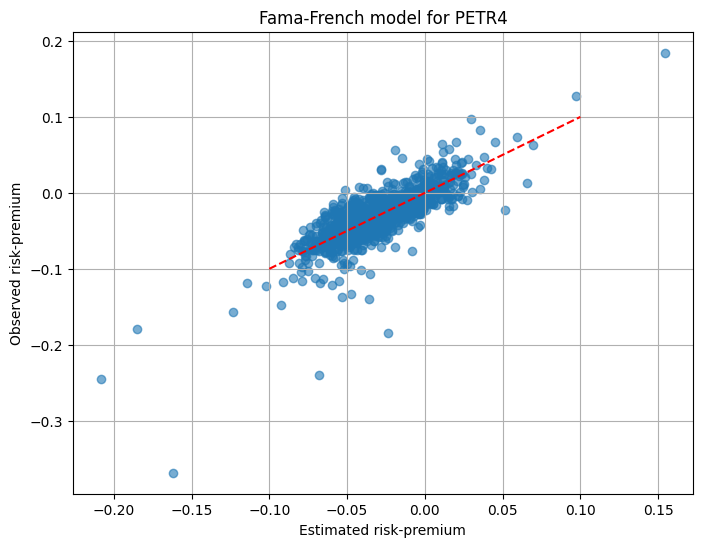

In [70]:
plotar_resultados(estimado, y, papel)